In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = "AppleGothic"
from IPython.display import Image

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy import stats
import scipy 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pycaret.regression import *
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas_profiling
import statsmodels.api as sm
from sklearn.decomposition import PCA
from statsmodels.miscmodels.ordinal_model import OrderedModel

### 자료 소개

**`grid_250_all.csv`는 전주시를 250x250 나눈 후 인구와 공간적 데이터, 그리고 범죄주의구간(폭행, 절도, 성폭행) 등급의 강도로 구성되어있다.  
해당 데이터를 통해 전주시의 3대 범죄 발생에 영향을 끼치는 요인을 파악 후 범죄 위험지역에 대해 판단해 보려한다.** 

**데이터는 국가정보포털에서 격자별 인구 및 건축물에 대한 데이터를 수집하였으며, 가로등 주차장 등은 각 데이터의 좌표를 기준으로 격자내의 개수를 입력하였다.**  
**범죄주의구간은 생활안전지도의 치안사고발생현황을 바탕으로 만들어진 범죄주의구간 (1~10등급)의 지도를 이용하여 격자별 주의구간의 등급을 산정했다. (각 등급의 최대값)**  
자료는 총 43개의 변수로 구성되어 있으며, 격자는 총 918개이다. 

#### raw data
<code>gird_250</code> = 전주시 범죄관련 데이터
- <code>INDEX</code> = 인덱스
- <code>ID</code> = 각 격자의 고유 ID
- <code>총인구</code> = 격자별 총인구
- <code>고등여성인구</code> = 격자별 고등학생 여성인구(이 변수는 성폭력 취약인구에 포함)
- <code>20대여성인구</code> = 격자별 20대 여성인구(이 변수는 성폭력 취약인구에 포함)
- <code>유소년인구</code> = 격자별 유소년인구(0~14세)
- <code>고령인구</code> = 격자별 고령인구(65세 이상)
- <code>30년이상35년미만건축물</code> = 30년이상 35년미만건축물의 수 
- <code>35년이상건축물</code> = 35년이상 건축물 
- <code>개별주택가격</code> = 격자별 개별주택가격의 평균 
- <code>공시지가</code> = 격자별 평균 공시지가 
- <code>행정동코드</code> = 격자가 속한 행정동
- <code>가로등</code> = 격자별 가로등의 수 
- <code>공영주차장</code> = 격자별 공영주차장수
- <code>공중화장실</code> = 격자별 공중화장실수
- <code>교육시설</code> = 격자별 교육시설의 수 (학원, 어린이집)
- <code>대규모점포</code> = 격자별 대규모 점포의 수 (홈플러스, 이마트 등)
- <code>대부업현황</code> = 격자별 대부업체의 수
- <code>룸살롱</code> = 격자별 룸살롱의 수 
- <code>버스정류장</code> = 격자별 버스정류장의 수
- <code>보안등</code> = 격자별 보안등의 수
- <code>상가</code> = 격자별 상가의 수 (교육시설,음식점,술집,도소매업 오락시설을 포함한 상가의 수)
- <code>숙박업소</code> = 격자별 숙박업소의 수
- <code>술집</code> = 격자별 술집 (술집+룸살롱)
- <code>어린이보호</code> = 격자별 어린이보호구역의 수
- <code>어린이집</code> = 격자별 어린이집 수
- <code>오락시설</code> = 격자별 오락시설 (노래방, 당구장, pc방 등)
- <code>원룸_오피스텔</code> = 격자별 원룸 및 오피스텔의 수
- <code>음식점</code> = 격자별 음식점 수
- <code>자율방범대</code> = 격자별 자율방범대 수
- <code>파출소</code> = 격자별 파출소의 수
- <code>cctv</code> = 격자별 cctv 수
- <code>신호등</code> = 격자별 신호등의 수
- <code>횡단보도</code> = 격자별 횡단보도의 수
- <code>GRADE_전체</code> = 격자별 범죄주의등급(2~11)

In [2]:
grid_250 = pd.read_csv('/Users/gimdong-wan/Desktop/DataCampus/data/real_data/250grid_all.csv')

In [3]:
grid_250 = grid_250.fillna(0)

In [4]:
grid_250['성폭력취약인구'] = grid_250['고등여성인구']+grid_250['20대여성인구']
grid_250['건축물(30_)'] = grid_250['건축물(30_34)']+grid_250['건축물(35)']
grid_250['GRADE_전체'] = grid_250['GRADE_전체'].apply(lambda x: x-1 if x>0 else x)
grid_250 = grid_250.drop(columns = ['20대여성인구','고등여성인구','INDEX'])

In [5]:
feat_N = grid_250[(grid_250['총인구']==0)&(grid_250['건축물(30_34)']==0)&(grid_250['건축물(35)']==0)&(grid_250['가로등']==0)&(grid_250['공영주차장']==0)&(grid_250['공중화장실']==0)&(grid_250['숙박업소']==0)
        &(grid_250['대규모점포']==0)&(grid_250['대부업현황']==0)&(grid_250['상가']==0)&(grid_250['어린이보호']==0)&(grid_250['원룸_오피스텔']==0)&(grid_250['cctv']==0)&(grid_250['신호등']==0)&(grid_250['횡단보도']==0)
        &(grid_250['버스정류장']==0)&(grid_250['개별주택가격']==0)] #target 제외 모든 변수가 0인 row
feat_Y = grid_250[(grid_250['총인구']>0)|(grid_250['건축물(30_34)']>0)|(grid_250['건축물(35)']>0)|(grid_250['가로등']>0)|(grid_250['공영주차장']>0)|(grid_250['공중화장실']>0)|(grid_250['숙박업소']>0)
        |(grid_250['대규모점포']>0)|(grid_250['대부업현황']>0)|(grid_250['상가']>0)|(grid_250['어린이보호']>0)|(grid_250['원룸_오피스텔']>0)|(grid_250['cctv']>0)|(grid_250['신호등']>0)|(grid_250['횡단보도']>0)
        |(grid_250['버스정류장']>0)|(grid_250['개별주택가격']>0)] #target 제외 모든 변수가 0보다 큰 row


In [6]:
print(len(grid_250),len(feat_N),len(feat_Y))

3498 1460 2038


- 모든 피쳐가 0인 행이 `1460`개이고, 한 피쳐라도 0보다 큰 행은 `2038`개 (공시지가와 타겟 제외)

#### 해당 격자들은 대부분 산지나, 강, 도로 등 시설물이 없는 곳들을 나타낸다.  
#### 따라서 본 연구는 범죄에 영향을 미치는 요인을 파악하기 위함이므로 제거해도 좋을 것 이라 판단된다.

In [7]:
new_grid = feat_Y

In [8]:
new_grid = new_grid[['ID', '총인구', '유소년인구', '고령인구', '건축물(30_34)', '건축물(35)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', '행정동면적',
       '성폭력취약인구', '건축물(30_)', 'GRADE_전체']]

### 전체 변수 간 상관관계 
 - 인구 사회학적 변수는 변수간 상관관계가 크며, 이는 다중공선성 제거를 위해 변수를 선택할 필요가 있다. 또한, 대부분 범죄 등급과도 큰 상관관계를 보이고 있다. 

#### 종속변수 (3대범죄)를 기반으로 한 상관계수 확인
 
- `인구` : 총인구 (0.69),성폭력취약인구(0.72), 유소년인구(0.69), 고령인구(0.68)
- `토지` : 30년 이상35년 미만 건축물(0.4), 35년 이상건축물(0.28), 30년 이상 건축물 (0.33),개별주택가격 (0.38), 공시지가(0.68)
- `시설물` : 가로등(0.54), 공영주차장(0.22), 공중화장실(0.28), 교육시설(0.64), 대규모점포(0.18), 대부업체현황(0.22), 룸살롱(0.26), 버스정류장(0.4), 보안등(0.26), 상가(0.76), 숙박업소(0.24), 술집(0.57), 어린이보호구역(0.23), 어린이집(0.39), 오락시설(0.52), 원룸_오피스텔(0.61), 음식점(0.71), 자율방범대(0.17), 파출소(0.12), cctv(0.56), 신호등(0.47), 횡단보도(0.65)

Text(0, 0.5, '범죄주의구간등급')

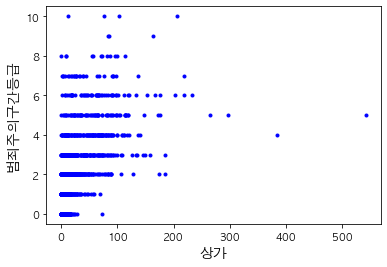

In [9]:
plt.plot('상가',  
         'GRADE_전체',
         linestyle='none',
         marker='o', 

         markersize=3,

         color='blue',
         data = new_grid)
plt.xlabel('상가', fontsize=14)

plt.ylabel('범죄주의구간등급', fontsize=14)

In [10]:
new_grid['개별주택가격'].max()

4706000000

In [11]:
new_grid = new_grid[new_grid['개별주택가격']<4000000000]

In [12]:
new_grid['상가'].max()

541

In [13]:
new_grid['음식점'].max()

161

In [14]:
new_grid = new_grid[new_grid['상가']<500]

In [15]:
numerical_feats = new_grid.dtypes[new_grid.dtypes != "object"].index.tolist()
numerical_feats.remove('GRADE_전체')
numerical_feats.remove('공영주차장')
numerical_feats.remove('공중화장실')
numerical_feats.remove('대규모점포')
numerical_feats.remove('대부업현황')
numerical_feats.remove('룸살롱')
numerical_feats.remove('버스정류장')
numerical_feats.remove('숙박업소')
numerical_feats.remove('술집')
numerical_feats.remove('어린이집')
numerical_feats.remove('오락시설')
numerical_feats.remove('cctv')
numerical_feats.remove('자율방범대')
numerical_feats.remove('파출소')


min_max_feats = list(new_grid.loc[:,['공영주차장','공중화장실','대규모점포','대부업현황','룸살롱','버스정류장','숙박업소','술집','어린이집','오락시설','cctv']].columns)
print("Number of Minmax features :", len(min_max_feats))
print("Number of Standard features: ", len(numerical_feats))

categorical_feats = new_grid.dtypes[new_grid.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Minmax features : 11
Number of Standard features:  19
Number of Categorical features:  2


In [16]:
scaler = StandardScaler()
new_grid[numerical_feats] = scaler.fit_transform(new_grid[numerical_feats])

In [17]:
scaler = MinMaxScaler()
new_grid[min_max_feats] = scaler.fit_transform(new_grid[min_max_feats])

In [18]:
new_grid['범죄빈도_4'] = 0

In [19]:
new_grid.loc[(new_grid['GRADE_전체']==0),'범죄빈도_4'] = 0
new_grid.loc[(new_grid['GRADE_전체']>0)&(new_grid['GRADE_전체']<4),'범죄빈도_4'] = 1
new_grid.loc[(new_grid['GRADE_전체']>=4)&(new_grid['GRADE_전체']<8),'범죄빈도_4'] = 2
new_grid.loc[(new_grid['GRADE_전체']>=8)&(new_grid['GRADE_전체']<11),'범죄빈도_4'] = 3

In [20]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_전체','범죄빈도_4']).columns)
feature = new_grid[feature_list]
target = new_grid[['범죄빈도_4']]

In [21]:
new_grid['GRADE_전체'].value_counts()

0.0     1022
1.0      338
2.0      194
3.0      182
4.0      128
5.0       72
6.0       54
7.0       27
8.0       12
10.0       4
9.0        3
Name: GRADE_전체, dtype: int64

In [22]:
new_grid['범죄빈도_4'].value_counts()

0    1022
1     714
2     281
3      19
Name: 범죄빈도_4, dtype: int64

In [181]:
feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','룸살롱','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)']].columns)
feature = new_grid[feature_list]
target = new_grid[['범죄빈도_4']]

In [182]:
model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
acc=accuracy_score(target,y_pred)
print('accuracy =', acc) 
con_mat = confusion_matrix(y_true=target, y_pred=y_pred) 
con_mat 

accuracy = 0.7224950884086444


array([[956,  65,   1,   0],
       [270, 383,  61,   0],
       [ 13, 141, 127,   0],
       [  0,   5,   9,   5]])

In [183]:
from sklearn.metrics import classification_report
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
print(classification_report(target, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1022
           1       0.64      0.54      0.59       714
           2       0.64      0.45      0.53       281
           3       1.00      0.26      0.42        19

    accuracy                           0.72      2036
   macro avg       0.76      0.55      0.59      2036
weighted avg       0.71      0.72      0.71      2036



In [189]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=False, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','룸살롱','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)']].columns)
    feature = df_train[feature_list]
    target = df_train[['범죄빈도_4']]
    
    
    model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(y_pred1,target)
    acc_2=accuracy_score(df_test['범죄빈도_4'],y_pred2)
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 0.70085995, 검증 Accuracy = 0.78431373
학습 Accuracy = 0.72437078, 검증 Accuracy = 0.70761671
학습 Accuracy = 0.71823204, 검증 Accuracy = 0.69287469
학습 Accuracy = 0.74892572, 검증 Accuracy = 0.61425061
학습 Accuracy = 0.71884592, 검증 Accuracy = 0.71744472
[0.78431373 0.70761671 0.69287469 0.61425061 0.71744472]


0.7033000915353856

In [194]:
feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','룸살롱','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)']].columns)
feature = new_grid[feature_list]
target = new_grid[['범죄빈도_4']]

In [195]:
model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
acc=accuracy_score(target,y_pred)
print('accuracy =', acc) 
con_mat = confusion_matrix(y_true=target, y_pred=y_pred) 
con_mat 

accuracy = 0.7224950884086444


array([[956,  65,   1,   0],
       [270, 383,  61,   0],
       [ 13, 141, 127,   0],
       [  0,   5,   9,   5]])

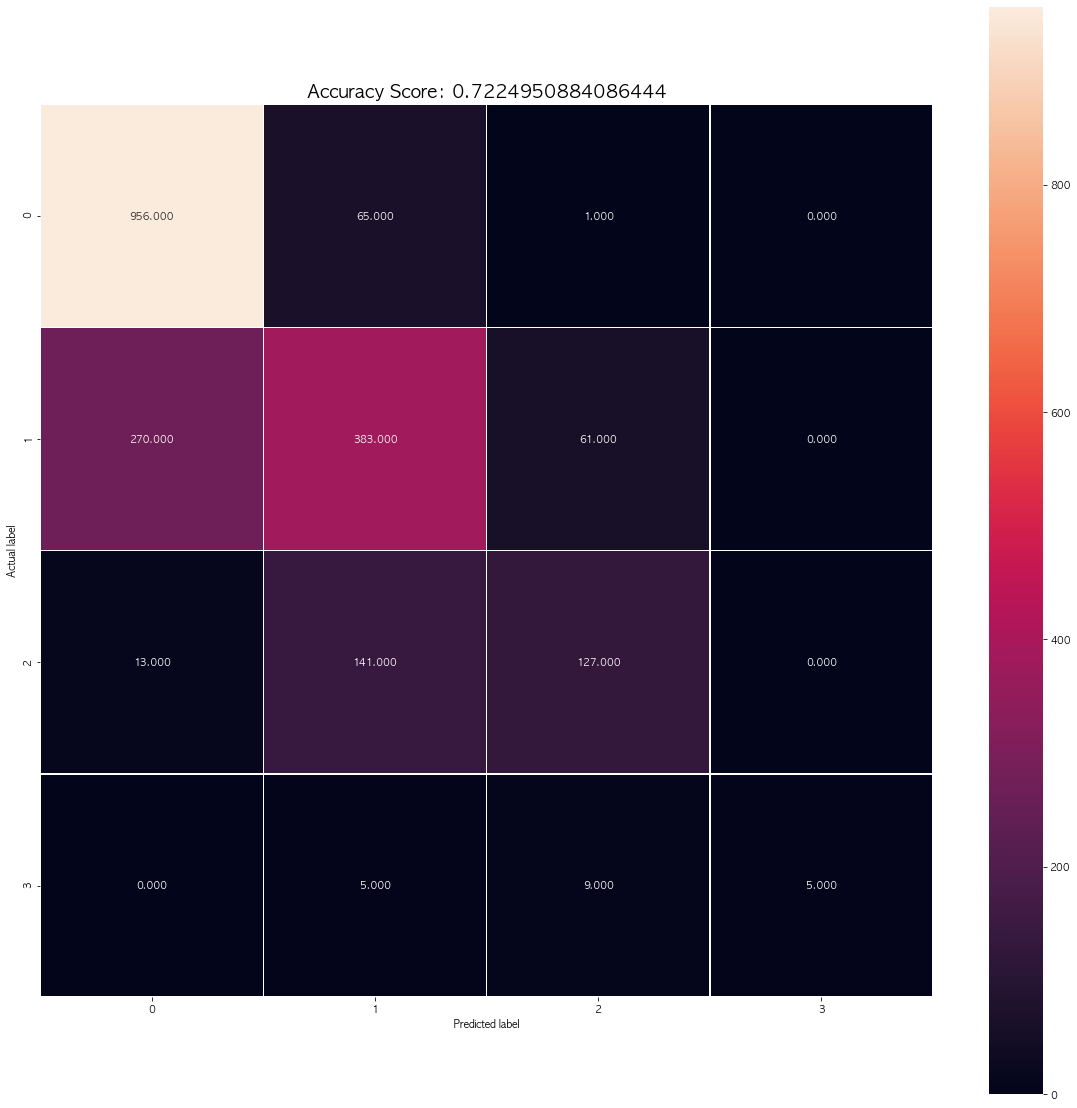

In [196]:
plt.figure(figsize=(20,20)) # chart size 
sns.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'Accuracy Score: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

In [199]:
feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','룸살롱','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)','cctv']].columns)

feature = new_grid[feature_list]
target = new_grid[['범죄빈도_4']]

In [200]:
feature_list

['공시지가',
 '숙박업소',
 '술집',
 '오락시설',
 '음식점',
 '룸살롱',
 '공영주차장',
 '가로등',
 '횡단보도',
 '신호등',
 '총인구',
 '원룸_오피스텔',
 '개별주택가격',
 '건축물(35)',
 'cctv']

In [201]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature,target, test_size=0.25, stratify=target, random_state=123456)

In [202]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.712
Mean accuracy score: 0.731


In [145]:
con_mat = confusion_matrix(y_true=y_test, y_pred=predicted) 

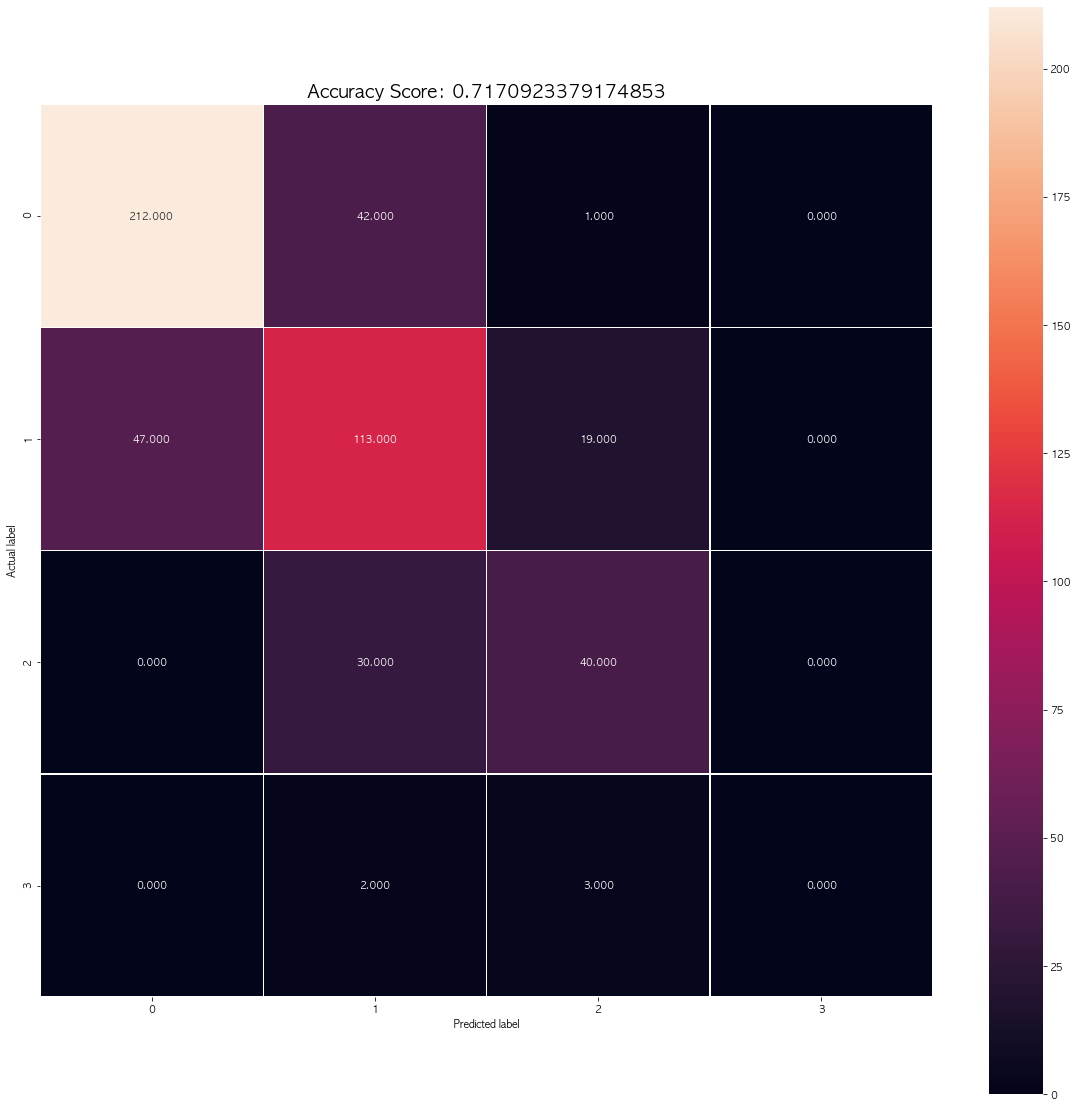

In [103]:
plt.figure(figsize=(20,20)) # chart size 
sns.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'Accuracy Score: {0}'.format(accuracy) 
plt.title(all_sample_title, size = 18) 
plt.show() 

In [204]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=False, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','룸살롱','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)','cctv']].columns)
    feature = df_train[feature_list]
    target = df_train[['범죄빈도_4']]
    
    
    model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(y_pred1,target)
    acc_2=accuracy_score(df_test['범죄빈도_4'],y_pred2)
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 1.00000000, 검증 Accuracy = 0.79656863
학습 Accuracy = 0.99938613, 검증 Accuracy = 0.70024570
학습 Accuracy = 0.99938613, 검증 Accuracy = 0.66093366
학습 Accuracy = 1.00000000, 검증 Accuracy = 0.63144963
학습 Accuracy = 0.99938613, 검증 Accuracy = 0.71990172
[0.79656863 0.7002457  0.66093366 0.63144963 0.71990172]


0.7018198679963386

In [188]:
np.unique(target.values)

array([0, 1, 2, 3])

In [105]:
list(feature.columns)

['공시지가',
 '숙박업소',
 '술집',
 '오락시설',
 '음식점',
 '룸살롱',
 '공영주차장',
 '가로등',
 '횡단보도',
 '신호등',
 '총인구',
 '원룸_오피스텔']

In [175]:
feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','룸살롱','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)']].columns)

feature = new_grid[feature_list]

In [176]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(feature)



PCA(n_components=3)

In [178]:
PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


PCA(n_components=3)

In [180]:
print('singular value :', pca.singular_values_)
print('singular vector :\n', pca.components_.T)

singular value : [87.49843759 48.59329378 44.8603691 ]
singular vector :
 [[ 4.32756970e-01 -1.52458619e-01 -8.32438890e-02]
 [ 7.73540586e-03 -5.13450893e-03  6.14309409e-03]
 [ 2.09056358e-02  8.55059602e-03  1.37464040e-02]
 [ 1.66600918e-02  4.14573878e-04  5.63900707e-03]
 [ 3.73708177e-01  7.15609480e-02  1.83601780e-01]
 [ 3.82466824e-03  2.20678752e-04  2.63948166e-03]
 [ 1.09783061e-02  3.79804578e-03  6.06836748e-04]
 [ 3.97123840e-01 -6.94754889e-02 -9.92134359e-02]
 [ 4.12355741e-01 -1.69834281e-01 -9.90382549e-02]
 [ 3.40069268e-01 -3.30567603e-01 -4.04729135e-01]
 [ 2.91317528e-01  2.17458273e-02  4.43326281e-02]
 [ 2.57398994e-01  5.50486086e-01  3.00272184e-01]
 [ 2.44408306e-01  6.19377839e-01 -6.40869015e-02]
 [ 1.33816059e-01 -3.76083890e-01  8.24258185e-01]]


In [203]:
#다중공선성확인
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(feature.values, i) for i in range(feature.shape[1])]
vif["features"] = feature.columns 
vif

,VIF Factor,features
0,2.737664,공시지가
1,1.614676,숙박업소
2,4.718963,술집
3,2.438999,오락시설
4,4.990380,음식점
5,1.961866,룸살롱
6,1.185483,공영주차장
7,1.955996,가로등
8,2.265786,횡단보도
9,1.835689,신호등
